<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 분석에 필요한 많이 쓰는 함수 미리 정의

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import model_from_json
import numpy as np
import scipy as sp
import scipy.stats
from datetime import datetime, timedelta

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def plot_train_result(hist):
    """
    학습의 결과, epoch 당 mean_absolute_error, R square, accuracy 등의 값을 Chart로 나타낸다.
    :param hist: hist = model.fit(....)
    :return:
    """
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    if 'mae' in hist.history:
        color = 'tab:red'
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('mean absolute error',color=color)
        plt.plot(hist.history['mae'],color=color)
        ax1.tick_params(axis='y', labelcolor=color)

    if 'r2' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('R square',color=color)
        plt.plot(hist.history['r2'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)

    if 'acc' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('accuracy',color=color)
        plt.plot(hist.history['acc'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Train history')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


def compare_with_past_y(past_y=None, comp_y=None, comp_index=[0, 14], forecast_y=None, window=30, forecast=15, title='Forecast result'):
    """
    최초 output으로 설정한 y값 대비, 예측한 결과 predit_y 값을 대조하여 Chart로 표출 한다.
    :param org_y:  최초 output으로 설정한 y값
    :param comp_y: 예측한 결과 predit_y 값
    :param comp_index: 예측한 결과 predit_y 값은 1일 후~15일 후 등, 배열의 형태, 몇번째 값을 표출 할지 설정
                        예: comp_index = [0,14]
                            1일차 및 15일차의 예측 값에 해당.
    :param window: time step 또는 몇일간의 시계열 정보를 input으로 할지 설정
                    해당 값은 sliding window (or moving average) 개념으로 dataset을 scan 하는 개념임 
    :param forecast: window 구간 이후 향후 몇일 간을 예측할지 설정
                    즉, regression으로 논하면 output의 개수에 해당.
    :param title:차트의 title
    :return: 
    """
    predit = []
    for fc in range(forecast):
        predit.append(list(np.concatenate((np.zeros(window + fc), comp_y[:, fc], np.zeros(forecast - fc - 1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    plt.figure(figsize=(16,8))
    plt.title('Display of past and future forecasts')
    plt.plot(past_y, label='past y')
    comp_ds = past_y.copy()
    for i in comp_index:
        comp_ds['past forecast ' + str(i)] = predit[i]
        plt.plot(comp_ds['past forecast ' + str(i)], label='past forecast ' + str(i))
    if not forecast_y is None:
      plt.plot(forecast_y,label='future forecast')
    plt.legend(loc="upper right")  
    plt.show()


def display_result(predit_y, ds_y, title=None):
    """
    예측 결과를 chart로 표출 한다.
    :param predit_y: 예측한 결과값 베열
    :param ds_y: 원시 y 값 (실측치)
    :param title: 
    :return: 
    """
    predic_ds = []
    # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
    # predit_y1 = predit_y * 100/24
    from datetime import datetime, timedelta
    last_date = ds_y.index[-1]
    for predict_count in predit_y[0]:
        last_date += timedelta(days=1)
        predic_ds.append({'date': last_date, 'Roaming register forecate': predict_count,
                          'Immigrantion forecast': int(predict_count * 100 / 24)})
    predic_ds = pd.DataFrame(predic_ds).set_index('date')
    predic_ds.plot( y='Immigrantion forecast', kind='bar',
                   title=('immigrantion forecast' if title is None else title))
    return predic_ds


def create_timeseries_dataset(x, y, window=30, forecast=15):
    """
    *** 매우 중요한 funcation ***
    window size로 시계열 dataset의 input feature 값(train_x)과 forecast 기간의 실측 y값(train_y)
    시계열의 마지막 window 크기의 input feature 값(test_x) 의 추출
    :param x: 실측 데이터 (pandas.DataFrame 형태)
    :param y: forecast 기간의 실측 y값(train_y, pandas.DataFrame 형태)
    :param window: 시계열 dataset의 input feature 값 size
    :param forecast: forecast 기간 
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :return: train_x, train_y, test_x
    """
    size = len(x.columns)
    train_x = []
    train_y = []

    x = x.to_numpy()
    y = y.to_numpy()
    print("input x:", x.shape)
    print("input y:", y.shape)
    for i in range(x.shape[0] - window - forecast + 1):
        sub_x = []
        for j in range(window):
            sub_x.append(x[i + j, :])
        train_x.append(sub_x)

        sub_y = []
        for z in range(forecast):
            sub_y.append(y[i + window + z,:])
        train_y.append(sub_y)

    # train_x ,train_y의 준비
    train_x = np.asarray(train_x)
    train_x = train_x.reshape(-1, window, size)
    train_y = np.asarray(train_y)
    if train_y.shape[2] ==1:
      train_y = train_y.reshape(-1,train_y.shape[1])
    elif train_y.shape[1] ==1:
      train_y = train_y.reshape(-1,train_y.shape[2])
    else:
      raise Exception('Not support shape!')

    test_x = x[x.shape[0] - window:x.shape[0], :]
    test_x = test_x.reshape(-1, window, size)

    print("outout train_x:", train_x.shape)
    print("outout train_y:", train_y.shape)
    print("outout test_x:", test_x.shape)

    return train_x, train_y, test_x


def create_model(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    """
    1D Covolution의 Deep Neural Network model 구성. (keras 기반)
    :param input_shape: 입력 배열 구조 예) 100,15 
    :param output: forecast 기간
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: model
    """
    import keras
    from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
    from keras.models import Sequential

    model = Sequential()
    model.add(Conv1D(128, 4, input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(output))
    model.add(Activation('linear'))

    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)

    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()

    return model


def train_model(model, x, y, epochs=30, trial=1, compile=False, verbose=0, metrics=['mae', r2]):
    """
    해당 model에 대한, 학습 시행
    :param model: 
    :param x: 입력 x값
    :param y: 출력 y값 = label 개수
    :param epochs: 
    :param trial: 1부터... 단지 print 용으로만
    :param compile: False - model을 compile하지 않는다.
                    True - 입력된 model을 compile 한다.
    :param verbose: 
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: 
    """
    if compile:
        model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)
    # print(model.summary())
    print(str(trial), "th Trial")
    if verbose == 0:
        hist = model.fit(x, y, epochs=epochs, verbose=0, callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit(x, y, epochs=epochs, verbose=1)
    return model, hist

def mean_confidence_interval(data, confidence=0.95):
       a = 1.0*np.array(data)
       n = len(a)
       m, se = np.mean(a), scipy.stats.sem(a)
       h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
       std = np.std(np.array(data))
       return m, m-h, m+h,std 

def statistical_results_analysis(ensemble_predit_y,ds_y, title=None):
    predic_ds = []
    last_date = ds_y.index[-1]
    ept = ensemble_predit_y.T
    for forecast_d in ept[:,0,:]:
      last_date += timedelta(days=1)
      m, mi,ma,std = mean_confidence_interval(forecast_d)
      ifmi = str(int(mi * 100/24))
      if mi < 0:
        ifmi=""
      predic_ds.append({'date':last_date,'Roaming register forecast(RRF)':int(m),'min':int(mi),'max':int(ma),
                        'RRF within the 95% confidence interval': str(int(mi)) + ' ~ ' + str(int(ma)),
                        'Standard deviation':std,
                        'Immigrantion forecast': ifmi + " ~ " + str(int(ma * 100/24))})
    predic_ds = pd.DataFrame(predic_ds).set_index('date')
    return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else log)),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


In [2]:


#공개된 3개의 Roaming Dataset을 load하여 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/Roaming_data.xlsx",encoding="utf-8")
rm = pd.concat([rm1,rm2,rm3], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
219020,20200501,vn,20200429,20200501,3
219021,20200501,vn,20200430,20200430,7
219022,20200501,vn,20200430,20200501,7
219023,20200501,vn,20200501,20200501,20


,count
arrival,
2019-10-31,91
2019-11-01,36
2019-11-02,120
2019-11-03,159
2019-11-04,179
...,...
2020-05-01,641
2020-05-02,502
2020-05-03,434


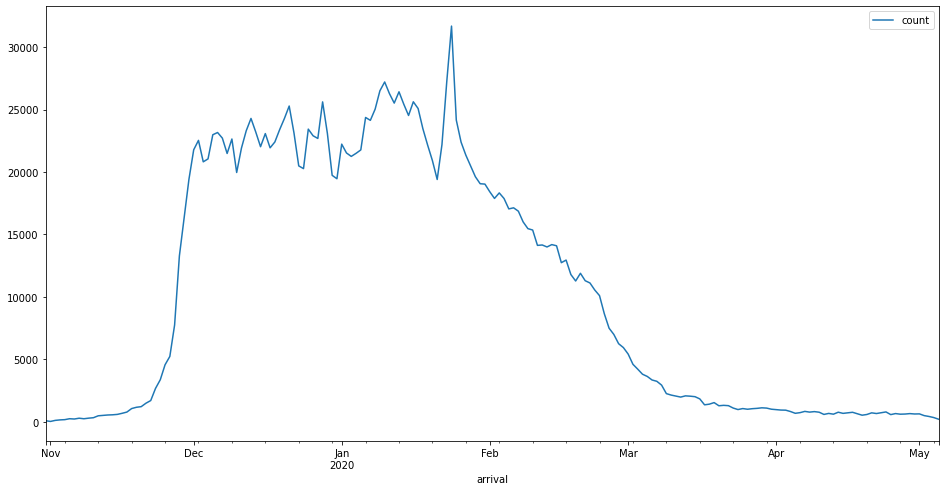

In [3]:

ds_y = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ds_y.index=  pd.to_datetime(ds_y.index, format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ds_y.plot(figsize=(16,8))
ds_y

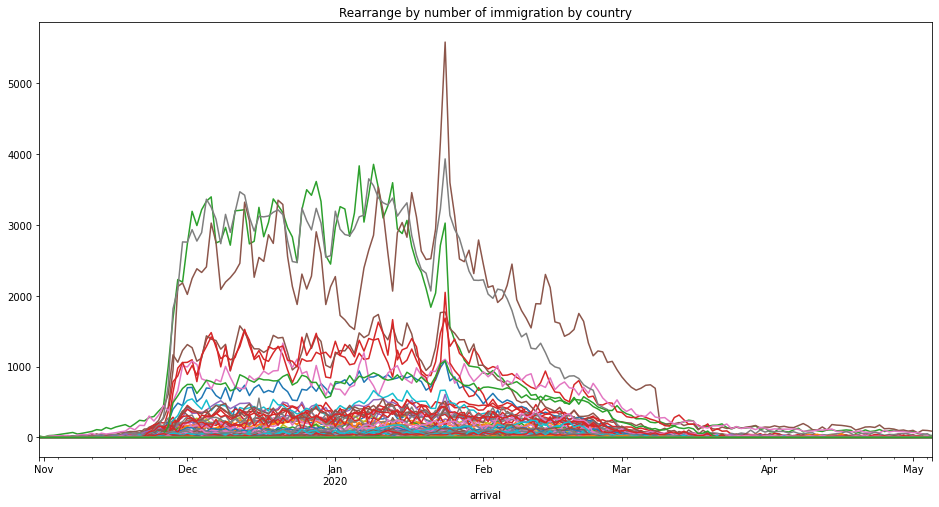

In [6]:

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
#ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso.plot(legend=False,figsize=(16,8),title="Rearrange by number of immigration by country")

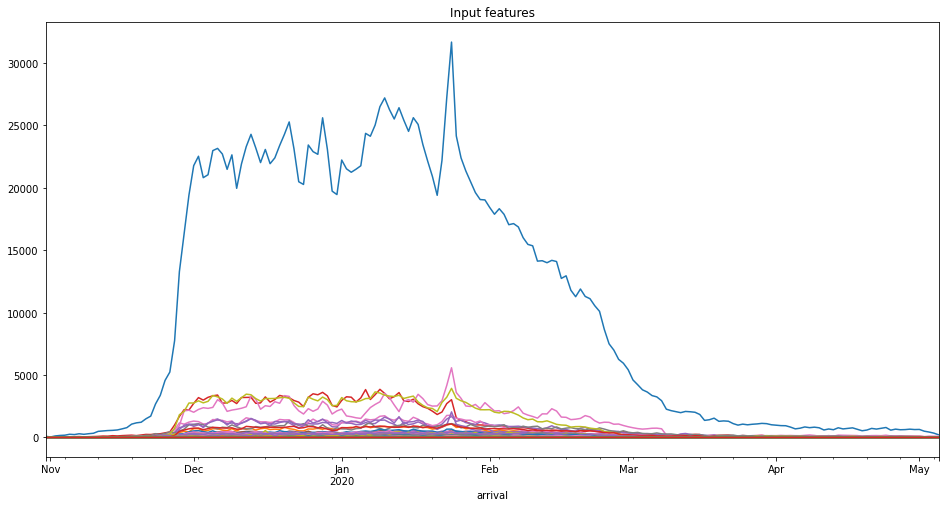

In [5]:
ds_y_iso = ds_y.join(ds_iso) # / np.max(ds_y.max())
ds_y_iso.plot(legend=False,figsize=(16,8),title='Input features')

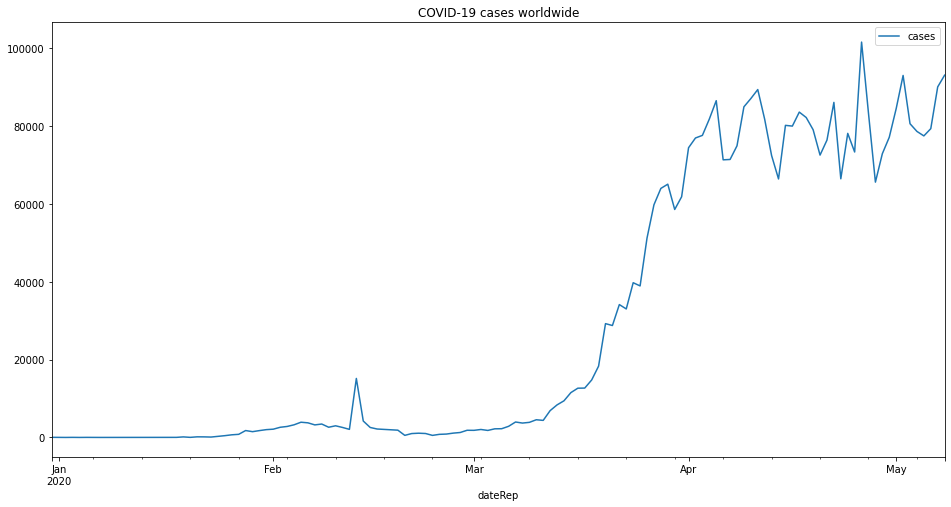

In [7]:
# 추가 데이터
# COVID-19 word wide dataset
# https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data

ds_cov_tp = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv",encoding="utf-8")
ds_cov = pd.DataFrame(ds_cov_tp.groupby('dateRep')['cases'].sum())
#date column을 datetime 으로 casting 한다.
ds_cov.index =  pd.to_datetime(ds_cov.index, format='%d/%m/%Y')
ds_cov = ds_cov.sort_index()
ds_cov.plot(figsize=(16,8),title='COVID-19 cases worldwide')


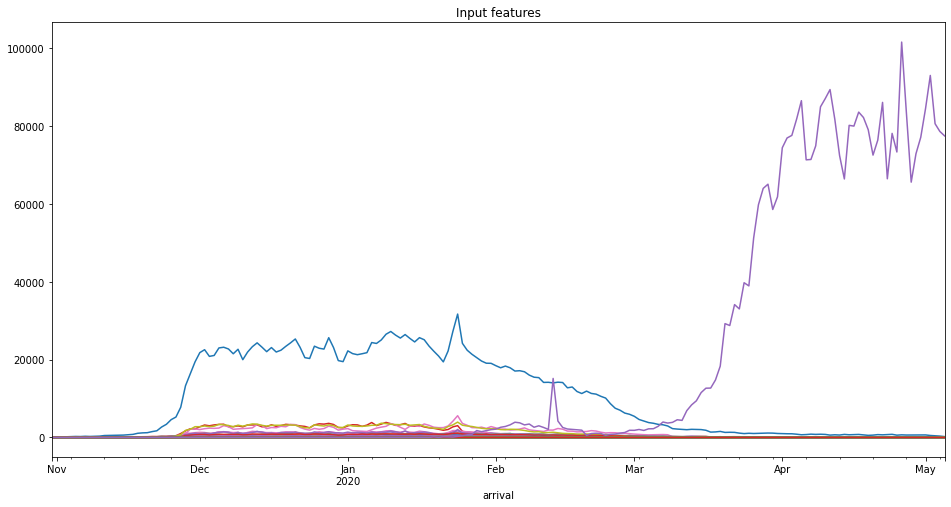

In [8]:
ds_y_iso_cov = ds_y_iso.join(ds_cov).fillna(0)
ds_y_iso_cov.plot(legend=False,figsize=(16,8),title='Input features')

In [9]:
# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/NewsList.xls")

ds_ns_tp =pd.concat([ns1, ns2, ns3], ignore_index=True, sort=False)
ds_ns_tp

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
112608,XINH2020050500081,Russia's top spacecraft designer reportedly di...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:06:31,Xinhua,COVID-19,Viral
112609,XINH2020050500083,Glimpse of a world under pandemic,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:00:35,Xinhua,COVID-19,Viral
112610,XINH2020050600003,Chinese clinical experience on COVID-19 treatm...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 00:00:51.0,2020-05-05 22:03:48,Xinhua,COVID-19,Viral
112611,XINH2020050600005,Volvo Cars sales in China returns to growth in...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 01:00:57.0,2020-05-05 23:39:14,Xinhua,COVID-19,Viral


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

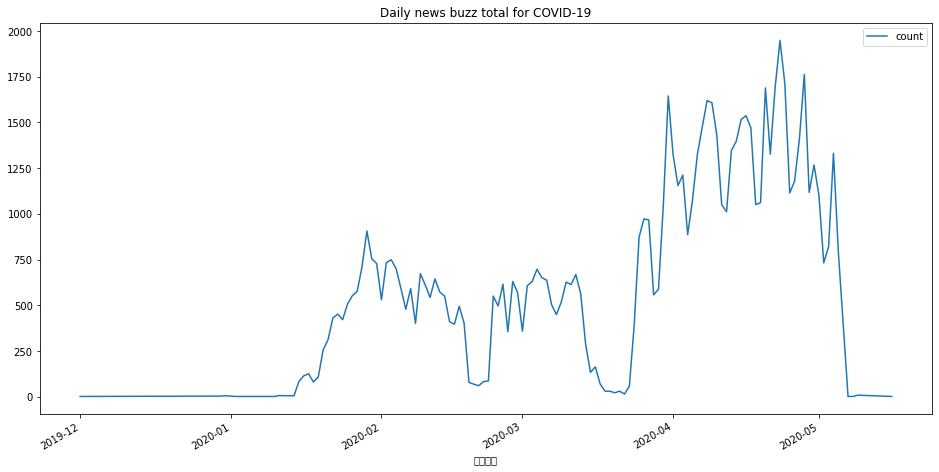

In [10]:
# ['감염병명'] == 'COVID-19' 인 것만 선별하여 일별 뉴스 발생량 구성 

ds_ns_tp = ds_ns_tp.loc[ds_ns_tp['감염병명'] == 'COVID-19']
ds_ns_tp['게시일자'] =  ds_ns_tp['게시일자'].str[:10]
ds_ns = pd.DataFrame(ds_ns_tp.groupby('게시일자')['감염병명'].count())
ds_ns = ds_ns.loc[ds_ns.index >= '2019-10-31']
ds_ns.index = pd.to_datetime(ds_ns.index, format='%Y-%m-%d')
ds_ns = ds_ns.rename(columns={"감염병명":"count"})
ds_ns.plot(figsize=(16,8),title="Daily news buzz total for COVID-19")


In [12]:
###########################################################################################################
# dolmani38의 google drive에서 corpus_embeddings.emb 의 다운로드                                          #
# dolmani38이외 Test 사용자는 이번 Cell은 실행하지 말고 다음 Cell에서 corpus_embeddings.emb를 만드세요.   #
###########################################################################################################
if True == 1:
  !pip install PyDrive
  import logging
  logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user(clear_output=False)
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  downloaded = drive.CreateFile({"id":"1FN7V0RxGACTNkusH9iQgFjXhicv1Lzei"})   # replace the id with id of file you want to access
  downloaded.GetContentFile("corpus_embeddings.emb")        # replace the file name with your file

  import os.path
  from os import path

  if path.exists("corpus_embeddings.emb"):
      print("Download complete!!")

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=6RTUQJDOddLmXrHoOGYPd79pHyS1k5&code_challenge=ZAzfEbbr1q5QpYUEIZxb8_GDNyxiZNOVGjw5aR_1wW8&prompt=consent&code_challenge_method=S256&access_type=offline

Enter verification code: ··········
Download complete!!


In [13]:
# 			1.2.3.2 News의 BERT embedding

# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...
# 시간 상당히 오래 걸림, 약 1시간 30분

#Start BERT embedding for news title...81785
#Length of corpus:81785
#Complete!!
#shape of corpus_embeddings :  (81785, 768)
#length of corpus :  81785
#End... elapsed time : 1:26:13.748154

# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

from timeit import default_timer as timer
from datetime import timedelta
import os.path
from os import path
import dill
from sentence_transformers import SentenceTransformer
import scipy.spatial

start = timer()

# embedder download...
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

print("Start BERT embedding for news title...{}".format(len(ds_ns_tp)))

# 뉴스 title만 corpus로 추출
# 기사 내용도 할수는 있으나 시간 넘 걸림...
corpus = []
for row in ds_ns_tp.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    corpus.append(title.lower())
    #print("{},{},{}".format(file_name,pub_datetime,title))

print("Length of corpus:{}".format(len(corpus)))

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()

else:
    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()

print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)
print("length of corpus : ",len(corpus))

#temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(ds_ns_tp.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

end = timer()

print("End... elapsed time : {}".format(timedelta(seconds=end-start)))

     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 645kB 12.3MB/s 
     |████████████████████████████████| 3.8MB 13.3MB/s 
     |████████████████████████████████| 890kB 27.6MB/s 
     |████████████████████████████████| 1.0MB 47.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=811fe09f74d2f32be4dce080a1c01476af454617d037ec3ba565807a2c76d72a
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3808c5c7aa52a2110815b08791738296057c8a297a76775951e0deb0bc787ee1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:05<00:00, 72.1MB/s]


Start BERT embedding for news title...81785
Length of corpus:81785
load from corpus_embeddings file...
Complete!!
shape of corpus_embeddings :  (81785, 768)
length of corpus :  81785
End... elapsed time : 0:00:34.379101


In [14]:
# 			1.2.3.3 News data의 feature 추출 (일종의 차원 축소)

# News에서 6개 feature 추출
# worse feature : 코로나 상황이 더 나빠지고 있다는 뉴스
# better feature : 상황이 좋아 지고 있나는 뉴스
# block feature : 격리, 입출입 차단 강화 관련 뉴스
# premit feature : 격리 해제, 입출입 완화 관련 뉴스
# yes_korea feature : 한국에 긍정적 내용 뉴스
# no_korea feature : 한국에 부정적 내용 뉴스

# 6개 feature를 추출하기 위해, 각 특성을 나타내는 간략한 sentence를 수동으로 만들고, 이를 전체 corpus_embeddings 에서 유사한 내용의 뉴스를 추출하여
# 해당 뉴스를 유사 내용으로 간주하고 labeling 한다.

def searchSentence(queries,Threshold_score=0.60, Topn=0,must_has_word=[]):
    index = {}
    n = len(queries)
    query_embeddings = embedder.encode(queries)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        for idx, distance in results[0:len(results) if Topn==0 else Topn]:
          score = 1-distance
          if not idx in index:
            index[idx] = 0.0
          if score > Threshold_score:
              if len(must_has_word) > 0:
                  if corpus[idx].strip().find(must_has_word[0]) >= 0:
                      index[idx] += float(score/n)
              else:
                  index[idx] += float(score/n)
              #print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
    return index

ds_ns_tp.reset_index(inplace = True, drop = True) 

queries_dict = {
    'worse':([],['infected corona','infected coronavirus ','increase confirmed','increase Infections','infectious increase','confirmed case incease','deaths incease','patients incease','lack prepare','not prepared','lack medical','lack preparedness']),
    'better':([],['decrease confirmed','decrease Infections','infectious decrease','confirmed case decrease','No confirmed','No case','deaths decrease','patients decrease','send supplies','order supplies','donates supplies','gives supplies','situation stability','situation stable','remains stable']),
    'block':([],['immigrants block','immigrants restrict','immigration block','immigration restrict','entrants block','entrants restrict','entry block','entry restrict','tourist block','tourist restrict','tourist Isolation','traveler block','traveler restrict','traveler Isolation','immigrants quarantine','entrants quarantine','entry quarantine','tourist quarantine','reinforce quarantine','reinforce diagnosis']),
    'permit':([],['immigrants permit','immigrants ease','immigration permit','immigration ease','entrants permit','entrants ease','entry permit','entry ease','tourist permit','tourist ease','release tourist ','traveler permit','release quarantine','release quarantine']),
    'yes_korea':(['korea'],['korea decrease confirmed','korea decrease Infections','korea infectious decrease','korea confirmed case decrease','korea No confirmed','korea No case','korea deaths decrease','korea patients decrease','korea send supplies','korea order supplies','korea donates supplies','korea gives supplies','korea situation stability','korea situation stable','korea remains stable','korea immigrants permit','korea immigrants ease','korea immigration permit','korea immigration ease','korea entrants permit','korea entrants ease','korea entry permit','korea entry ease','korea tourist permit','korea tourist ease','korea release tourist ','korea traveler permit','korea release quarantine','korea release quarantine']),
    'no_korea':(['korea'],['korea infected corona','korea infected coronavirus ','korea increase confirmed','korea increase Infections','korea infectious increase','korea confirmed case incease','korea deaths incease','korea patients incease','korea lack prepare','korea not prepared','korea lack medical','korea lack preparedness','korea immigrants block','korea immigrants restrict','korea immigration block','korea immigration restrict','korea entrants block','korea entrants restrict','korea entry block','korea entry restrict','korea tourist block','korea tourist restrict','korea tourist Isolation','korea traveler block','korea traveler restrict','korea traveler Isolation','korea immigrants quarantine','korea entrants quarantine','korea entry quarantine','korea tourist quarantine','korea reinforce quarantine','korea reinforce diagnosis'])
}
# Query sentences:

for query_key in queries_dict.keys():
  ds_ns_tp[query_key] = 0
  idxs = searchSentence(queries_dict[query_key][1],Threshold_score = 0.6,must_has_word=queries_dict[query_key][0])
  print('{} result rows:{} query count:{}'.format(query_key,len(idxs),len(queries_dict[query_key][1])))
  ds_ns_tp.loc[list(idxs.keys()),query_key] = list(idxs.values())

ds_ns_tp[['게시일자','worse','better','block','permit','yes_korea','no_korea','제목']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


worse result rows:81785 query count:12


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


better result rows:81785 query count:15
block result rows:81785 query count:20
permit result rows:81785 query count:14
yes_korea result rows:81785 query count:29
no_korea result rows:81785 query count:32


,게시일자,worse,better,block,permit,yes_korea,no_korea,제목
0,2020-01-25,0.054946,0.0,0.0,0.0,0.0,0.0,Rwanda Public Notice on Novel Coronavirus
1,2020-01-31,0.000000,0.0,0.0,0.0,0.0,0.0,WHO ramps up preparedness for novel coronaviru...
2,2020-02-01,0.051934,0.0,0.0,0.0,0.0,0.0,Rwanda hastens safety measures against novel c...
3,2020-02-02,0.000000,0.0,0.0,0.0,0.0,0.0,Eritrea Strengthening Preparedness to 2019 nov...
4,2020-02-04,0.000000,0.0,0.0,0.0,0.0,0.0,WHO supports Botswana’s preparedness and respo...
...,...,...,...,...,...,...,...,...
81780,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,"Spotlight: Europeans restart ""normal"" life in ..."
81781,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Russia's top spacecraft designer reportedly di...
81782,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Glimpse of a world under pandemic
81783,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Chinese clinical experience on COVID-19 treatm...


In [15]:
# 6개 feature를 일자 기준 하나의 dataframe으로 join

cov_1 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['worse'].sum())
cov_2 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['better'].sum())
cov_3 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['block'].sum())
cov_4 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['permit'].sum())
cov_5 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['yes_korea'].sum())
cov_6 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['no_korea'].sum())

ds_ns_cov = ds_ns.join(cov_1).join(cov_2).join(cov_3).join(cov_4).join(cov_5).join(cov_6)
ds_ns_cov

,count,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,,
2019-12-01,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,2,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,3,0.058952,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,5,0.170601,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-05,793,5.810915,0.516218,0.435219,0.223337,0.0,0.0
2020-05-07,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

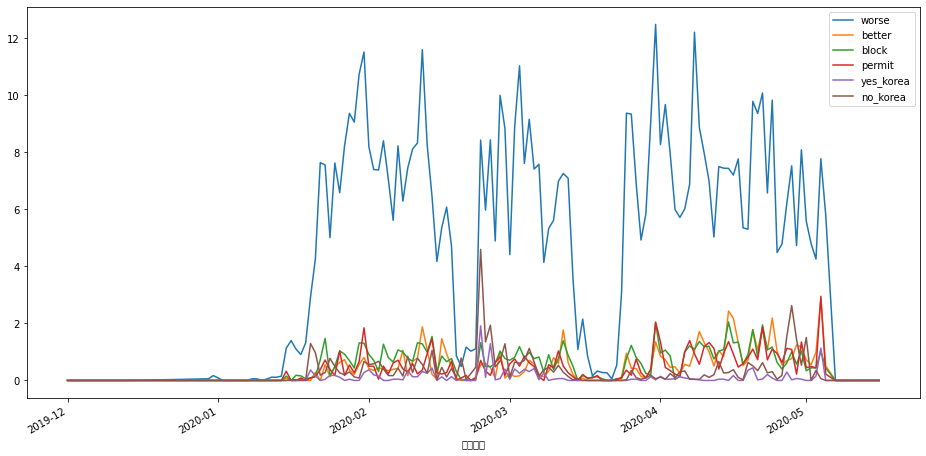

In [16]:
# 추출된 feature의 추세 확인
ds_ns_cov.plot(y=['worse','better','block','permit','yes_korea','no_korea'],figsize=(16,8))

,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,0.019651,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,0.034120,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...
2020-05-05,0.007328,0.000651,0.000549,0.000282,0.0,0.0
2020-05-07,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

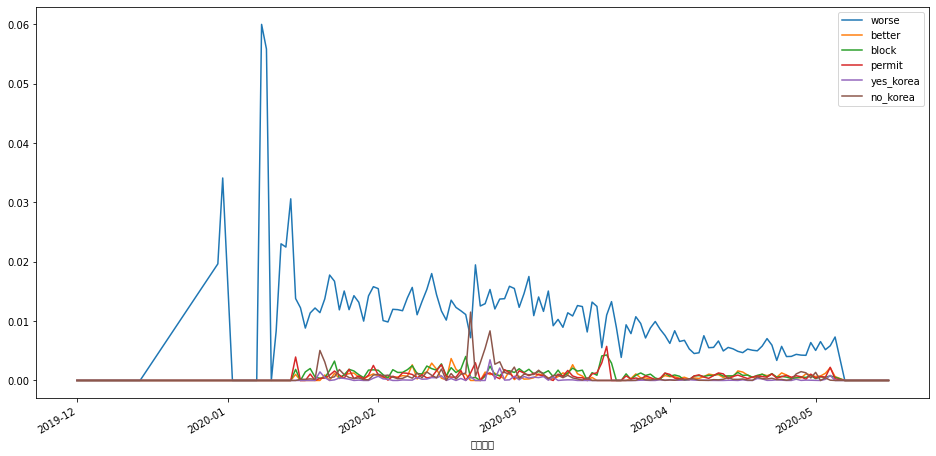

In [17]:
#			1.2.3.4 News feature의 Normalization

ds_ns_cov_n = pd.DataFrame({'worse':ds_ns_cov['worse']/ds_ns_cov['count']})
ds_ns_cov_n["better"] = ds_ns_cov['better']/ds_ns_cov['count']
ds_ns_cov_n["block"] = ds_ns_cov['block']/ds_ns_cov['count']
ds_ns_cov_n["permit"] = ds_ns_cov['permit']/ds_ns_cov['count']
ds_ns_cov_n["yes_korea"] = ds_ns_cov['yes_korea']/ds_ns_cov['count']
ds_ns_cov_n["no_korea"] = ds_ns_cov['no_korea']/ds_ns_cov['count']
# Normalization 한 feature의 추세 확인
ds_ns_cov_n.plot(figsize=(16,8))
ds_ns_cov_n

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

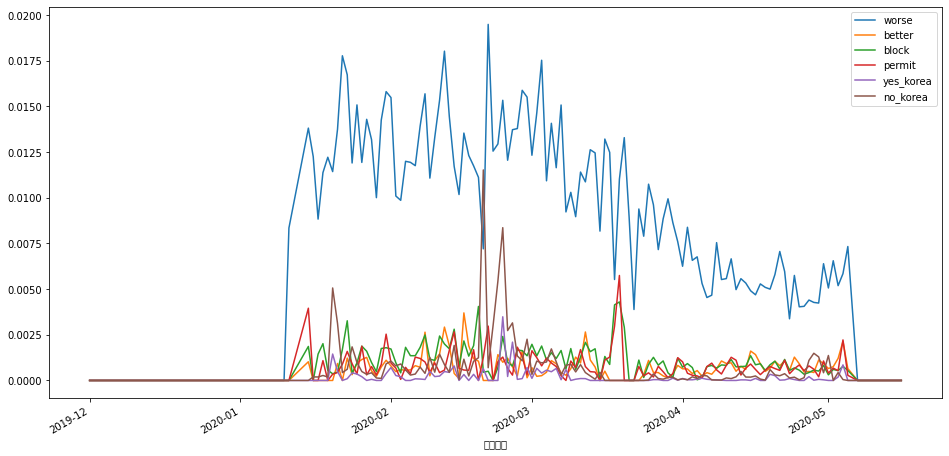

In [18]:
#			1.2.3.5 Outlier 제거

# worse 성분의 outlier filtering
ds_ns_cov_n_f = ds_ns_cov_n[ds_ns_cov_n["worse"] < 0.0195]
ds_ns_cov_n_f.plot(figsize=(16,8))

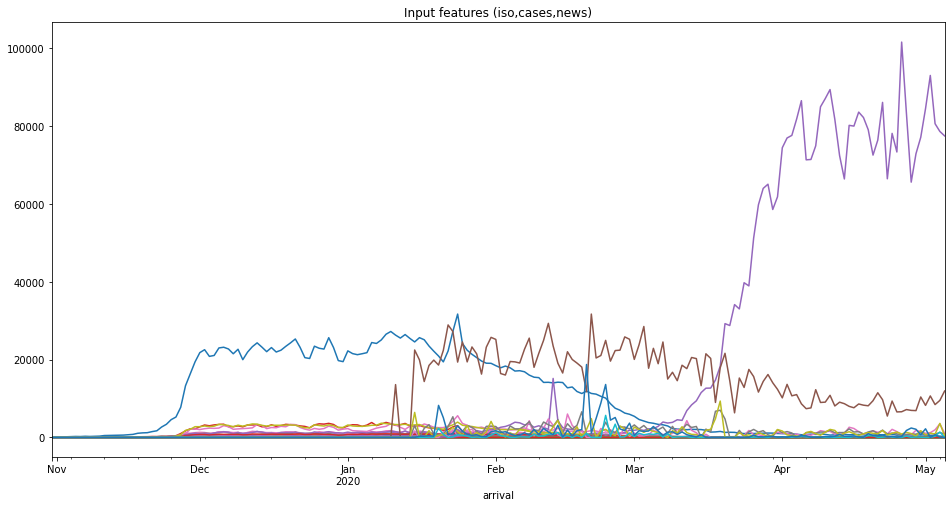

In [19]:
# ds_y 크기로 scale 조정
ds_ns_cov_n_f_s = (ds_ns_cov_n_f / np.max(ds_ns_cov_n_f.max())) * np.max(ds_y.max())
ds_y_iso_cov_ns = ds_y_iso_cov.join(ds_ns_cov_n_f_s).fillna(0)
ds_y_iso_cov_ns.plot(legend=False,figsize=(16,8),title='Input features (iso,cases,news)')

In [20]:
# Dataset 전처리 완료!!!!!!!!!!!!!!!!

ds_y_iso_cov_ns

,count,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,...,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,cases,worse,better,block,permit,yes_korea,no_korea
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,91,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-01,36,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-02,120,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-03,159,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13.0,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-04,179,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6.0,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,641,6.0,9.0,85,25.0,28.0,100,0.0,0.0,0.0,0.0,6.0,0.0,3.0,35.0,3.0,22.0,68.0,29.0,6.0,0.0,0.0,15.0,3.0,6.0,3.0,0.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,3.0,0.0,35.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84440.0,8229.208094,1061.374587,501.685034,660.924058,0.000000,2221.129569
2020-05-02,502,3.0,13.0,56,20.0,9.0,65,19.0,0.0,0.0,0.0,3.0,0.0,0.0,9.0,0.0,10.0,67.0,26.0,0.0,0.0,0.0,12.0,0.0,3.0,6.0,0.0,0.0,0.0,6.0,7.0,3.0,0.0,0.0,0.0,0.0,6.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92964.0,10652.721578,1226.802863,983.162128,1095.694009,0.000000,0.000000
2020-05-03,434,3.0,0.0,51,12.0,9.0,102,3.0,3.0,0.0,0.0,3.0,0.0,0.0,6.0,0.0,6.0,49.0,45.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,6.0,8.0,0.0,0.0,0.0,3.0,0.0,22.0,0.0,12.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80568.0,8435.194778,1961.821203,873.372722,871.472509,304.678574,704.097762


input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_85 (Conv1D)           (None, 30, 128)           92800     
_________________________________________________________________
activation_113 (Activation)  (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_85 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 15, 128)           65664     
_________________________________________________________________
activation_114 (Activation)  (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 7, 128)            0      

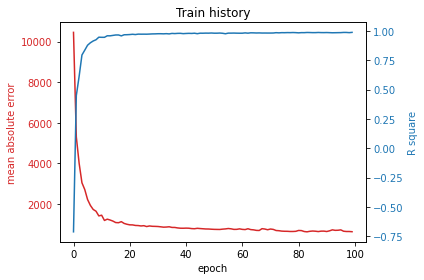

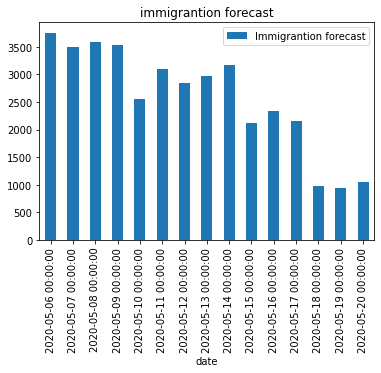

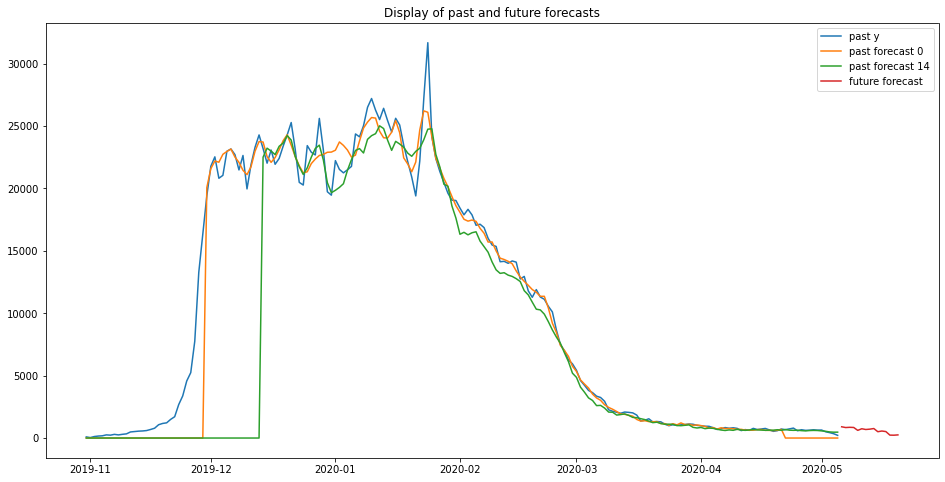

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,901.463928,3756
2020-05-07,840.860596,3503
2020-05-08,859.934937,3583
2020-05-09,846.246155,3526
2020-05-10,614.320801,2559
2020-05-11,744.030457,3100
2020-05-12,684.322571,2851
2020-05-13,711.534607,2964
2020-05-14,760.791626,3169


In [91]:

# 30일간의 Data를 통해, 향후 15일을 1D Convolution Regression을 사용하여 예측.

window = 30
forecast=15

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y,window=window,forecast=forecast)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=200,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)
train_x_y,train_x_y.shape
test_x_y = model.predict(test_x)
ds_s_r = display_result(test_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecate'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r



input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 30, 128)           92800     
_________________________________________________________________
activation_105 (Activation)  (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 15, 128)           65664     
_________________________________________________________________
activation_106 (Activation)  (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 7, 128)            0      

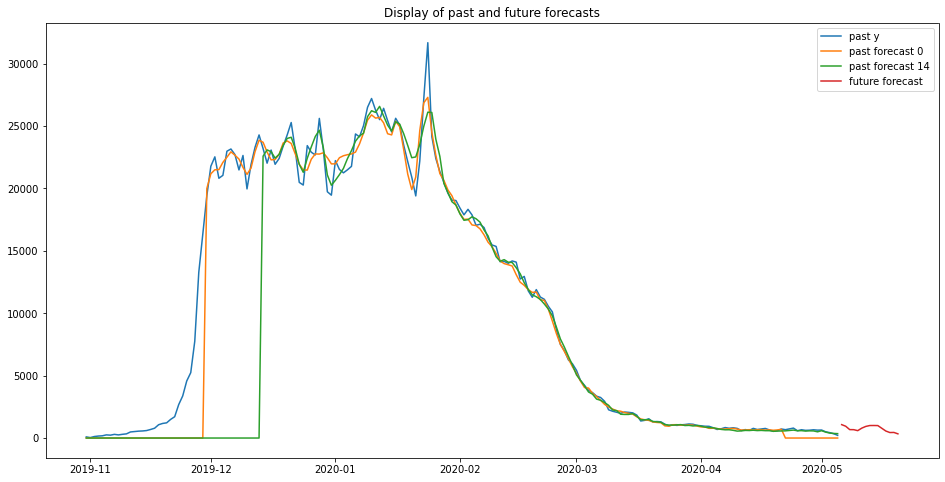

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,1074,-114 ~ 2264,390.951294,~ 9434
2020-05-07,947,-205 ~ 2100,378.968842,~ 8753
2020-05-08,675,-226 ~ 1577,296.356903,~ 6571
2020-05-09,670,-621 ~ 1962,424.715637,~ 8177
2020-05-10,592,-333 ~ 1518,304.279877,~ 6325
2020-05-11,792,61 ~ 1524,240.582214,254 ~ 6353
2020-05-12,930,211 ~ 1650,236.488571,880 ~ 6876
2020-05-13,1002,449 ~ 1554,181.593155,1874 ~ 6478
2020-05-14,1004,370 ~ 1637,208.219223,1544 ~ 6823


In [89]:

# 동일한 방법으로 ensemble 에 의해 예측, 통계적 신뢰수준을 적용하여 로밍등록자 예측을 구간추정 한다.

import dill
from keras.models import model_from_json

def ensemble_train(train_x,train_y,ensemble_count=25,epoch=200):
    model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
    ensemble = []
    for i in range(ensemble_count):
      json_file = open("model.json", "r")
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json) 
      model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
      model,hist = train_model(model,train_x,train_y,epochs=epoch,trial=(i+1))
      ensemble.append(model)
        
    print("Wait! saving ensemble model...")    
    file = open("ensemble.mdl", 'wb')
    dill.dump(ensemble, file)
    file.close()

    print("Complete!!")
    return ensemble

# 		ensemble_predict method define~
def ensemble_predict(ensemble_model,input_x):
  if ensemble_model is None:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()
  ensemble_predit_y =  np.asarray([m.predict(input_x) for m in ensemble_model])
  predit_y = np.mean(ensemble_predit_y,axis=0)
  return predit_y, ensemble_predit_y


window = 30
forecast=15

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y,window=window,forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=100,epoch=200)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
test_x_y,ensemble_test_x_y = ensemble_predict(ensemble_model,test_x)
ds_s_r = statistical_results_analysis(ensemble_test_x_y,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout test_x: (1, 40, 181)
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 40, 128)           92800     
_________________________________________________________________
activation_101 (Activation)  (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 20, 128)           65664     
_________________________________________________________________
activation_102 (Activation)  (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 10, 128)           0   

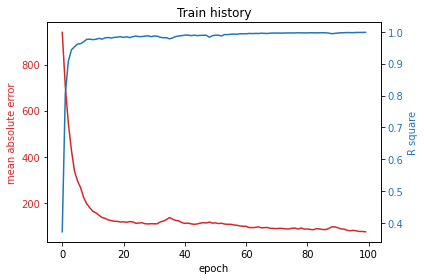

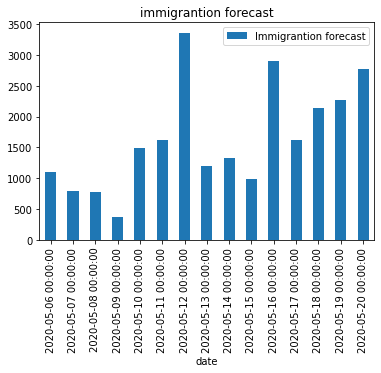

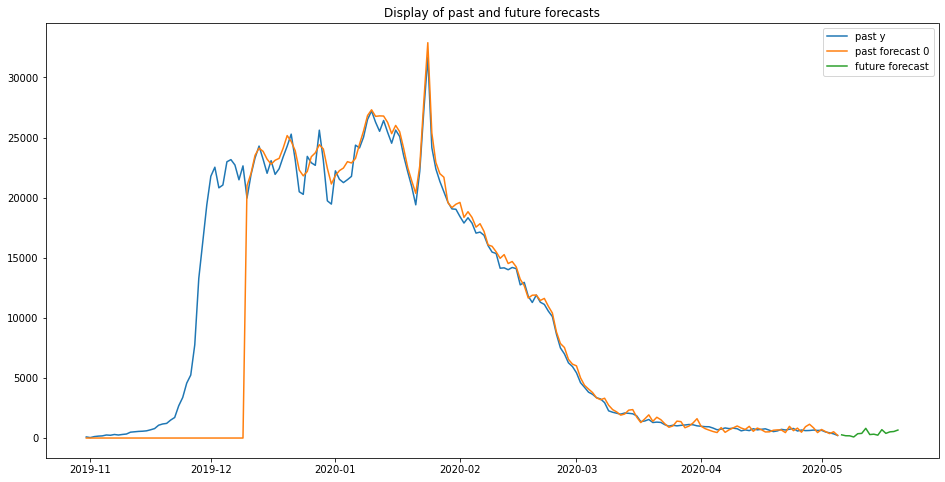

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,264.791168,1103
2020-05-07,190.272598,792
2020-05-08,184.675186,769
2020-05-09,87.766953,365
2020-05-10,359.692078,1498
2020-05-11,387.214264,1613
2020-05-12,807.264954,3363
2020-05-13,288.610199,1202
2020-05-14,320.040955,1333


In [88]:
# window = 40, forecast=1 로, 하루 앞을 예측하고 output을 재귀적으로 입력하여 15일까지를 예측한다.
#이렇게 하기 위해서는 trainset에서 y값이 x값과 같아야 한다.

def recursive_forecast(model,test_x,recursion=15):
  predict = []
  for i in range(recursion):
    predit_y = model.predict(test_x)
    predict.append(predit_y[0][0])
    new_test_x = test_x.reshape(test_x.shape[1],test_x.shape[2])
    new_test_x = np.concatenate((new_test_x, predit_y), axis=0)[1:window+1,:]
    test_x = new_test_x.reshape(1,new_test_x.shape[0],new_test_x.shape[1])
  return np.asarray(predict).reshape(1,recursion)

window = 40
forecast=1
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=200,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)
test_x_y = recursive_forecast(model,test_x)
ds_s_r = display_result(test_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y,forecast_y= ds_s_r['Roaming register forecate'], comp_index=[0],window=window, forecast=forecast)
ds_s_r

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout test_x: (1, 40, 181)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 40, 128)           92800     
_________________________________________________________________
activation_93 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 20, 128)           65664     
_________________________________________________________________
activation_94 (Activation)   (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 10, 128)           0   

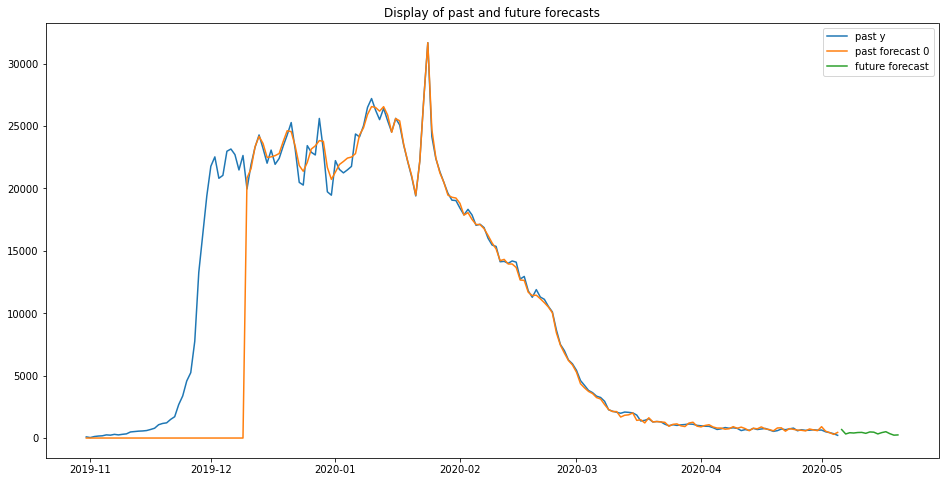

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,680,-336 ~ 1697,334.299530,~ 7074
2020-05-07,326,-26 ~ 680,116.139900,~ 2833
2020-05-08,425,-202 ~ 1053,206.505951,~ 4390
2020-05-09,403,79 ~ 726,106.258636,332 ~ 3026
2020-05-10,442,-259 ~ 1144,230.764465,~ 4769
2020-05-11,452,-147 ~ 1053,197.410416,~ 4388
2020-05-12,377,-210 ~ 964,193.171310,~ 4019
2020-05-13,488,-229 ~ 1207,236.139618,~ 5029
2020-05-14,470,281 ~ 659,62.066830,1174 ~ 2747


In [86]:
# 		ensemble_predict method define~
def ensemble_recursive_forecast(ensemble_model,input_x):
  if ensemble_model is None:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()
  ensemble_predit_y =  np.asarray([recursive_forecast(m,input_x) for m in ensemble_model])
  predit_y = np.mean(ensemble_predit_y,axis=0)
  return predit_y, ensemble_predit_y

window = 40
forecast=1
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=100,epoch=200)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
test_x_y,ensemble_test_x_y = ensemble_recursive_forecast(ensemble_model,test_x)
ds_s_r = statistical_results_analysis(ensemble_test_x_y,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

In [0]:
# LSTM
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=size*2, return_sequences=True, input_shape=(window, size)))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2, return_sequences=True))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2, return_sequences=True))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2))
model.add(Dropout(0.02))

model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")



In [0]:
ensemble = []
for i in range(1):
  model,hist = train_combined_model(i+1,epochs=20,verbose=0,metrics=['mae',r2])
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")

In [0]:

predit_y,ensemble_predit_y = ensemble_predict(train_x)
predit_y,predit_y.shape

In [0]:
compare_backdata(predit_y)